In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %cd "/content/drive/MyDrive/cs7643-deep-learning/project"
%cd "/content/drive/My Drive/cs7643/"


/content/drive/My Drive/cs7643


In [3]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fde49e61-45f9-22c8-a4c0-116bdc57cbf1)


In [4]:
!pip install -q -U watermark

In [5]:
!pip install -qq transformers

     |████████████████████████████████| 2.1MB 6.7MB/s 
     |████████████████████████████████| 3.3MB 22.4MB/s 
     |████████████████████████████████| 901kB 31.9MB/s 


In [6]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, \
BertTokenizerFast, AdamWeightDecay, get_cosine_with_hard_restarts_schedule_with_warmup, \
get_cosine_schedule_with_warmup, get_constant_schedule_with_warmup

import torch

import gc
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

if torch.cuda.is_available():
  torch.cuda.empty_cache()

In [7]:
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 6
OPTIMIZER_LR = 1e-5  # 3e-5
FREEZE = False

In [8]:
# df = pd.read_csv("yelp_reduced_60k_20k-humorous.csv")
df = pd.read_csv("yelp_reduced_45,410_50-50-humor-split.csv")


In [9]:
# data = pd.read_csv("yelp_humor_merged_v1.csv")
# data = pd.read_csv("./data/yelp_merged_data.csv")
# data

In [10]:
# word_cnt_threshold=400
# humor_threshold=10

In [11]:
# df = data[(data['word_count'] <= word_cnt_threshold) & ((data['funny']>=humor_threshold) | (data['funny'] == 0))]
# df

In [12]:
# df['humor'].value_counts()

In [13]:
# df['funny'].value_counts()

In [14]:
# humor_sample = min(10000, df['humor'].value_counts()[1])
# humor_sample

In [15]:
# not_humor_split = 0.5
# not_humor_sample = int(humor_sample * (not_humor_split) / (1 - not_humor_split))
# not_humor_sample

In [16]:
# df_humor = df[df['humor']==1]
# df_humor = df_humor.sample(n=humor_sample, random_state=RANDOM_SEED)
# df_humor

In [17]:
# df_not_humor = df[df['humor']==0]
# df_not_humor = df_not_humor.sample(n=not_humor_sample, random_state=RANDOM_SEED)
# df_not_humor

In [18]:
# df = pd.concat([df_humor, df_not_humor])
# df = pd.read_csv("yelp_reduced.csv")
# df = pd.read_csv("yelp_reduced_20k.csv")
# df

In [19]:
class_names = ['not funny', 'funny']

In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [22]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, truncation=True)
  token_lens.append(len(tokens))

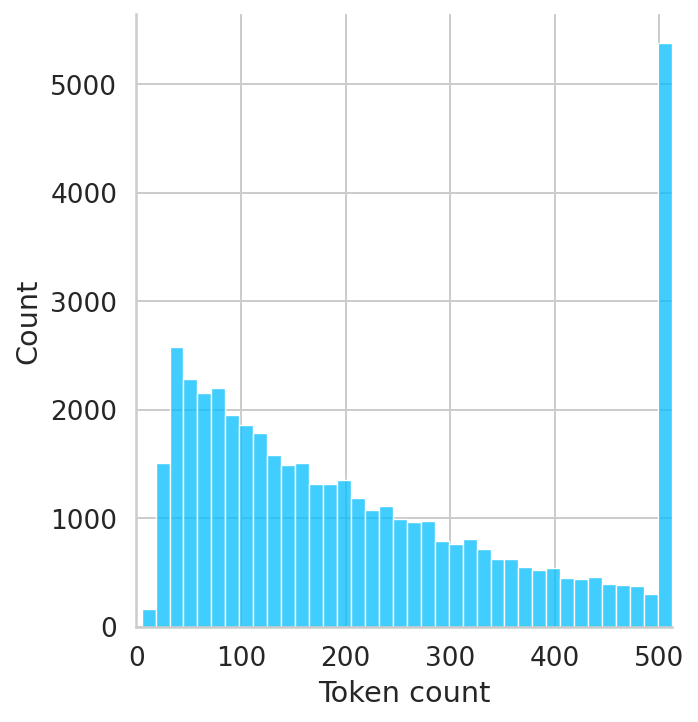

In [23]:
sns.displot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [24]:
(np.array(token_lens) == 512).sum()

5051

In [25]:
# del data, df_humor, df_not_humor, tokens
del tokens
gc.collect()
torch.cuda.empty_cache()

In [26]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [27]:


df_train, df_test = train_test_split(df, test_size=0.3, stratify=df.humor, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test.humor, random_state=RANDOM_SEED)

In [28]:
df_train['humor'].value_counts()

0    15894
1    15893
Name: humor, dtype: int64

In [29]:
df_val['humor'].value_counts()

1    3406
0    3405
Name: humor, dtype: int64

In [30]:
df_test['humor'].value_counts()

1    3406
0    3406
Name: humor, dtype: int64

In [31]:
df_train.shape, df_val.shape, df_test.shape

((31787, 9), (6811, 9), (6812, 9))

In [32]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.humor.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [33]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [34]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [35]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [36]:
class HumorClassifier(nn.Module):

  def __init__(self, n_classes):
    super(HumorClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,  return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [37]:
model = HumorClassifier(len(class_names))
model = model.to(device)

In [38]:
# freeze all the parameters
if FREEZE:
    for param in model.bert.parameters():
        param.requires_grad = False
        # print(param)

In [39]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [40]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5901, 0.4099],
        [0.3687, 0.6313],
        [0.5095, 0.4905],
        [0.4051, 0.5949],
        [0.2444, 0.7556],
        [0.2762, 0.7238],
        [0.4246, 0.5754],
        [0.3237, 0.6763]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [41]:
optimizer = AdamW(model.parameters(), lr=OPTIMIZER_LR, correct_bias=False)
# optimizer = AdaFactor(learning_rate=OPTIMIZER_LR)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# scheduler = get_cosine_schedule_with_warmup(
#   optimizer,
#   num_warmup_steps=0,
#   num_training_steps=total_steps
# )

loss_fn = nn.CrossEntropyLoss().to(device)

In [42]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
----------
Train loss 0.44655033237468145 accuracy 0.8067134363104415
Val   loss 0.41725761930244 accuracy 0.8280722360886801

Epoch 2/6
----------
Train loss 0.3700913385183198 accuracy 0.8644728977254853
Val   loss 0.4945341184387692 accuracy 0.8305681985024225

Epoch 3/6
----------
Train loss 0.3270976580097633 accuracy 0.9060936860980905
Val   loss 0.741354318398779 accuracy 0.8274849508148583

Epoch 4/6
----------
Train loss 0.26345955008335875 accuracy 0.9349104980023281
Val   loss 0.9203210567501855 accuracy 0.8224930259873733

Epoch 5/6
----------
Train loss 0.21183817885312178 accuracy 0.9513952244628308
Val   loss 1.0367813175034484 accuracy 0.8210248128028189

Epoch 6/6
----------
Train loss 0.1770560700190863 accuracy 0.9616195299965395
Val   loss 1.119194351429055 accuracy 0.8125091763324034

CPU times: user 1h 58min 23s, sys: 1h 17min 17s, total: 3h 15min 40s
Wall time: 3h 15min 1s


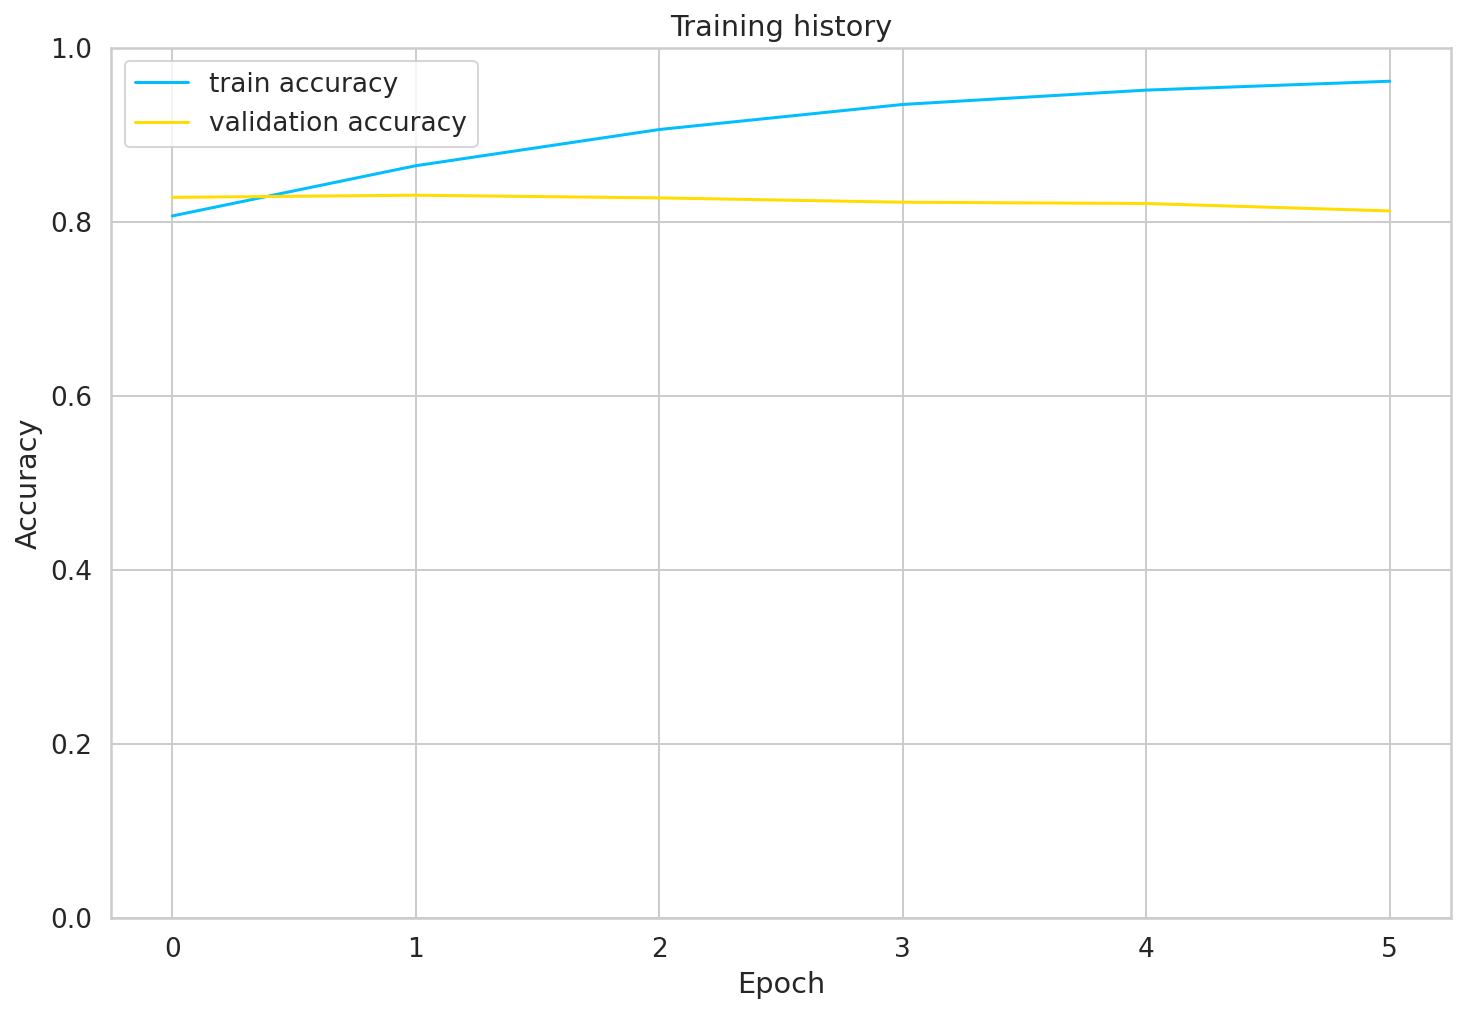

In [45]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [46]:
model = HumorClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [47]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8279506752789195

In [48]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [49]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   not funny       0.82      0.85      0.83      3406
       funny       0.84      0.81      0.82      3406

    accuracy                           0.83      6812
   macro avg       0.83      0.83      0.83      6812
weighted avg       0.83      0.83      0.83      6812



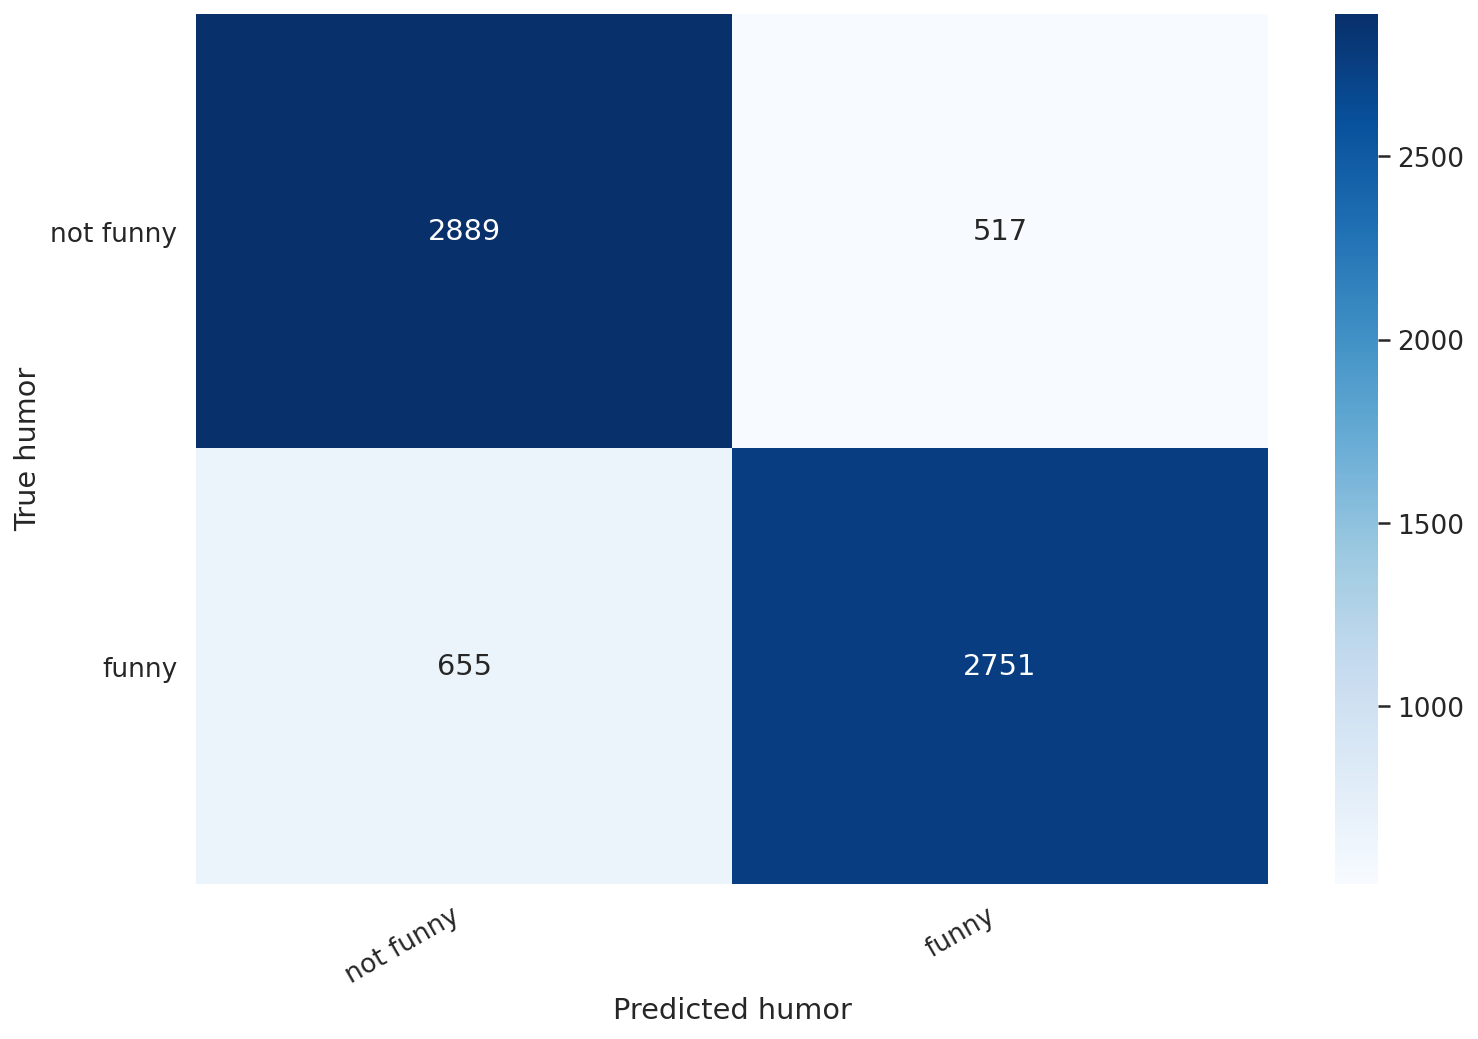

In [51]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True humor')
  plt.xlabel('Predicted humor');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [52]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [53]:
print("\n".join(wrap(review_text)))
print()
print(f'True humor: {class_names[true_sentiment]}')

I was craving ramen a few weeks ago, and out of nowhere and old friend
happened to call and ask if I wanted to tag along to G-men. I am so
glad that I said yes. I had been to this storefront back in the day
when it was a different business, so I was having a major case of
deja-vu when I walked in the doors. We got there right at 5:30, so it
had just opened. The wait staff was very polite, and helpful. I had a
lot of questions since G-men seems to do ramen a little differently
than most ramen spots. I settled on the "RCMP" bowl. All I can say is
it was amazing. The flavours were rich and satisfying, and the serving
size was huge. The food was also very fast. The restaurant filled very
quickly, so I wouldn't recommend it for a quick meal, as many people
were waiting to be seated. If you have a bit of time however, or if it
is near opening time, check it out. I guarantee you'll like it.

True humor: not funny


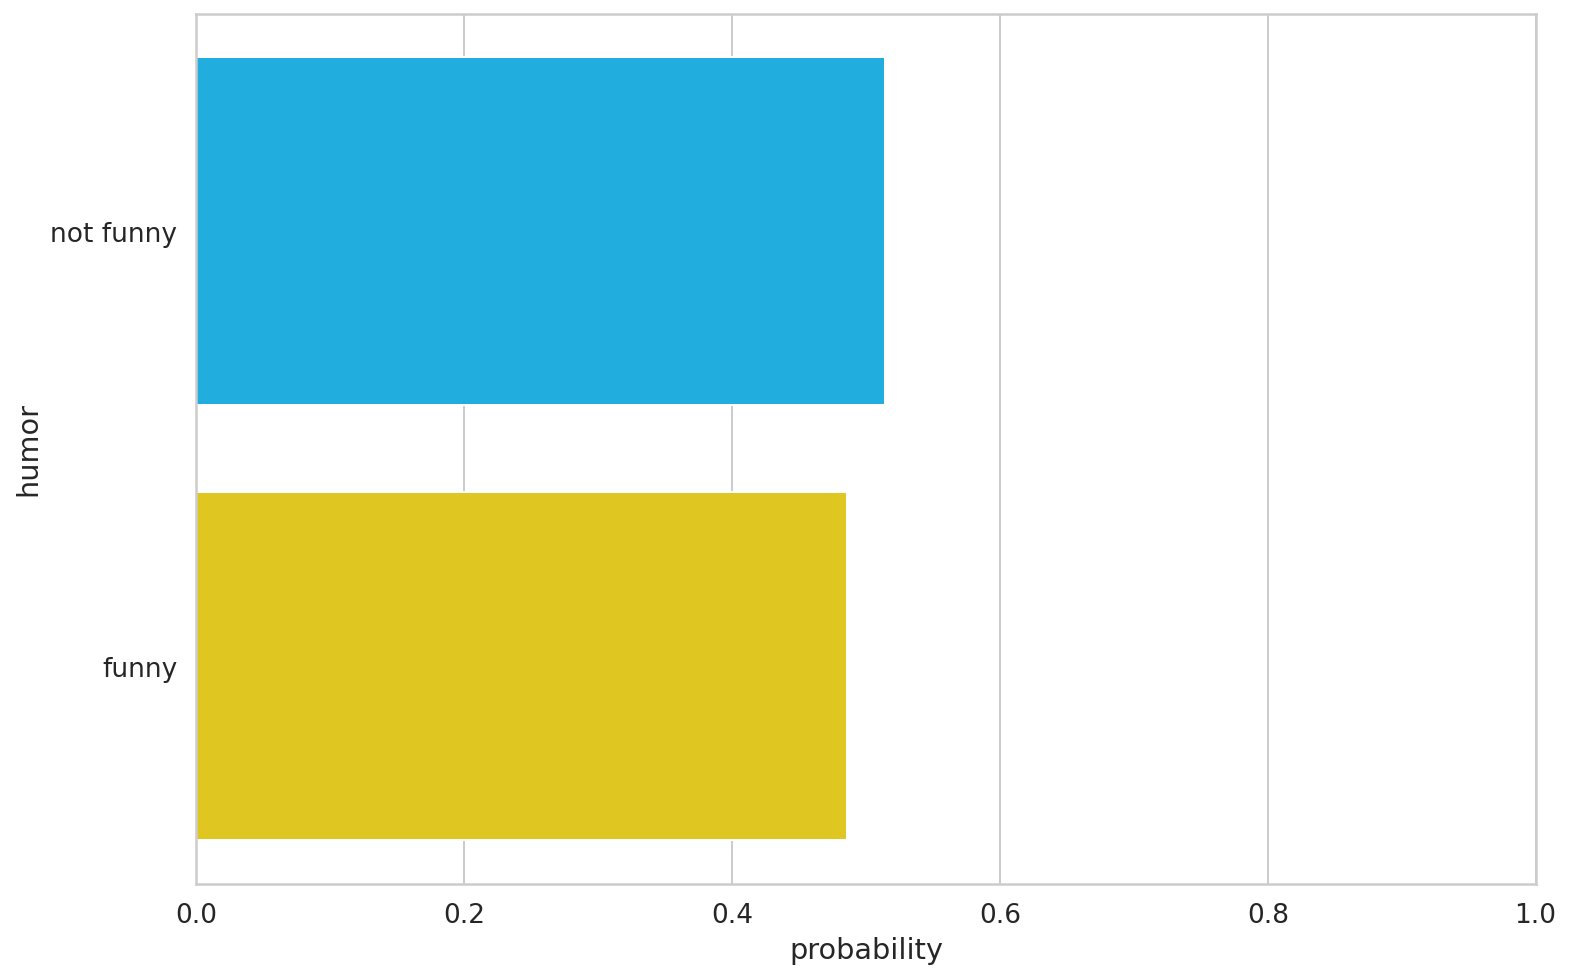

In [54]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('humor')
plt.xlabel('probability')
plt.xlim([0, 1]);